___Author(s): Chaojie Feng___<br/>
___Collaborator(s): XXX___<br/>
___External Resources: XXX___<br/>
___Specific Contributions: XXX___<br/>
___Aggregate Contributions: XXX___<br/>


# 1. System Definition
You will consider a 2 wheeled robot similar to the one shown in Fig. 1. It has two wheels of radius r = 20mm,
separated by a distance w = 85mm. It drags a tail for stability.
Figure 1: Two wheeled tank-drive robot
1
Each wheel is powered independently by a bi-directional continuous rotation servo—part number FS90R—with
the angular velocity of the wheel controlled by a signal from the microcontroller. This allows the robot to drive
forwards or backwards at variable speed, or turn with any turning radius. There may be slippage between the wheels
and the floor; assume the resulting effective angular speed of the wheels is normal with a standard deviation of 5%
of the max motor speed.
The robot has two laser range sensors—part number VL53L0X—and an inertial measurement unit (IMU)—part
number MPU-9250. The output of these sensors will be a function of the positional state of the robot within its
environment.
The robot will be driving within a rectangular environment of length L = 750mm and width W = 500mm,
consisting of 4 walls bounding an open space.

# 2. Mathematical Setup

The state of your robot will consist of the 3DOF pose of the robot in 2D space. You may also want to include
velocity terms. In addition, your state may include a gyro bias term for greater accuracy. Thus, your robot state
will have at least 3 variables, but may have more.
Your control input will be the angular velocity values you prescribe for each wheel, for a total of 2 input variables.
Your sensor output from the laser range sensors will consist of the distance to a wall in a straight line in front of the
robot and the distance to a wall in a straight line to the right of the robot. The IMU will return an absolute bearing
indicating the angle of the robot with respect to magnetic north, and can also return an angular rate measurement.
We will ignore the accelerometer on the IMU. Thus the robot system will produce 3 or 4 output values.

## 2.1 Define System Model

Befor start building the system model, we need to define our constant variables:

$$r = wheel \ radius = 20 \ mm$$
$$d = wheel \ distance = 85 \ mm$$



First of all, we want to design our state variables as well as system dynamics. We want to track the position of robot $(x,y)$ and the heading of robot $(h)$. That means we need 3 state variables $x$,$y$ and $h$. Since the gyroscope in our IMU has a bias. We can eliminate the effect of bias by either adding an extra bias in our state or subtracting it in our measurement. Let's put the bias as one of our state and construct a state vector $x$:

$$\mathbf x = \begin{bmatrix}x \\ y\\ \theta \\ b\end{bmatrix}$$

and our input control parameter $u$ reprents input motor angular velocities for both left wheel and right wheel respectively:

$$\mathbf u = \begin{bmatrix} u1 \\ u2 \end{bmatrix}$$

We will thus model our real system with some noise as input:

$$\bar x = f(x, u) + \mathcal{N}(0, Q)$$
$$ u = u + \mathcal{N}(0,M) $$

We will assign $Q$ and $M$ to denote covariance matrix of state and input

Also, the dynamics of system can be characterized as:

$$\bar{\begin{bmatrix}x\\y\\\theta\\b\end{bmatrix}} = \begin{bmatrix}x\\y\\\theta\\b\end{bmatrix} + 
\begin{bmatrix} \frac{1}2 \cos(\theta)(u_1+u_2)r \\
 \frac{1}2 \sin(\theta)(u_1+u_2)r \\
\frac{(u_1-u_0)r}d \\
0\end{bmatrix}\Delta t$$

## 2.2 Define Measurement Model

The robot has two laser sensor measuring the position and one IMU sensor measuring the heading. The laser sensor will be installed to detect the distance from robot head to the wall as well as to detect the distance from robot right side to the wall. Based on the measurements, robot state $x$ and $y$ can be calculated. Also, heading measurement and bias can be retreived directly from sensor without converting. The measurement model, along with noise $w$ can be described as:

$$\mathbf z = \begin{bmatrix} z_f\\z_r\\\theta\\b\end{bmatrix} = h(x) + w$$

Where $h$ can be described by four different models based on measured heading angles $\theta_m$:

If $\theta_m$ is between $0^o$ and $90^o$:
$$\mathbf h_1 =\begin{bmatrix} (l-x)cos(\theta)+(w-y)sin(\theta)\\
(l-x)sin(\theta)+ycos(\theta)\\
\theta\\
b\end{bmatrix}$$

If $\theta_m$ is between $90^o$ and $180^o$:
$$\mathbf h_2 =\begin{bmatrix} (w-y)sin(\theta)+xcos(\theta)\\
(l-x)sin(\theta)+(w-y)cos(\theta)\\
\theta\\
b\end{bmatrix}$$

If $\theta_m$ is between $180^o$ and $270^o$:
$$\mathbf h_3 =\begin{bmatrix} -xcos(\theta)-ysin(\theta)\\
-(w-y)cos(\theta)+-xsin(\theta)\\
\theta\\
b\end{bmatrix}$$

If $\theta_m$ is between $270^o$ and $360^o$:
$$\mathbf h_4 =\begin{bmatrix} -ysin(\theta)+(l-x)cos(\theta)\\
-xsin(\theta)+ycos(\theta)\\
\theta\\
b\end{bmatrix}$$


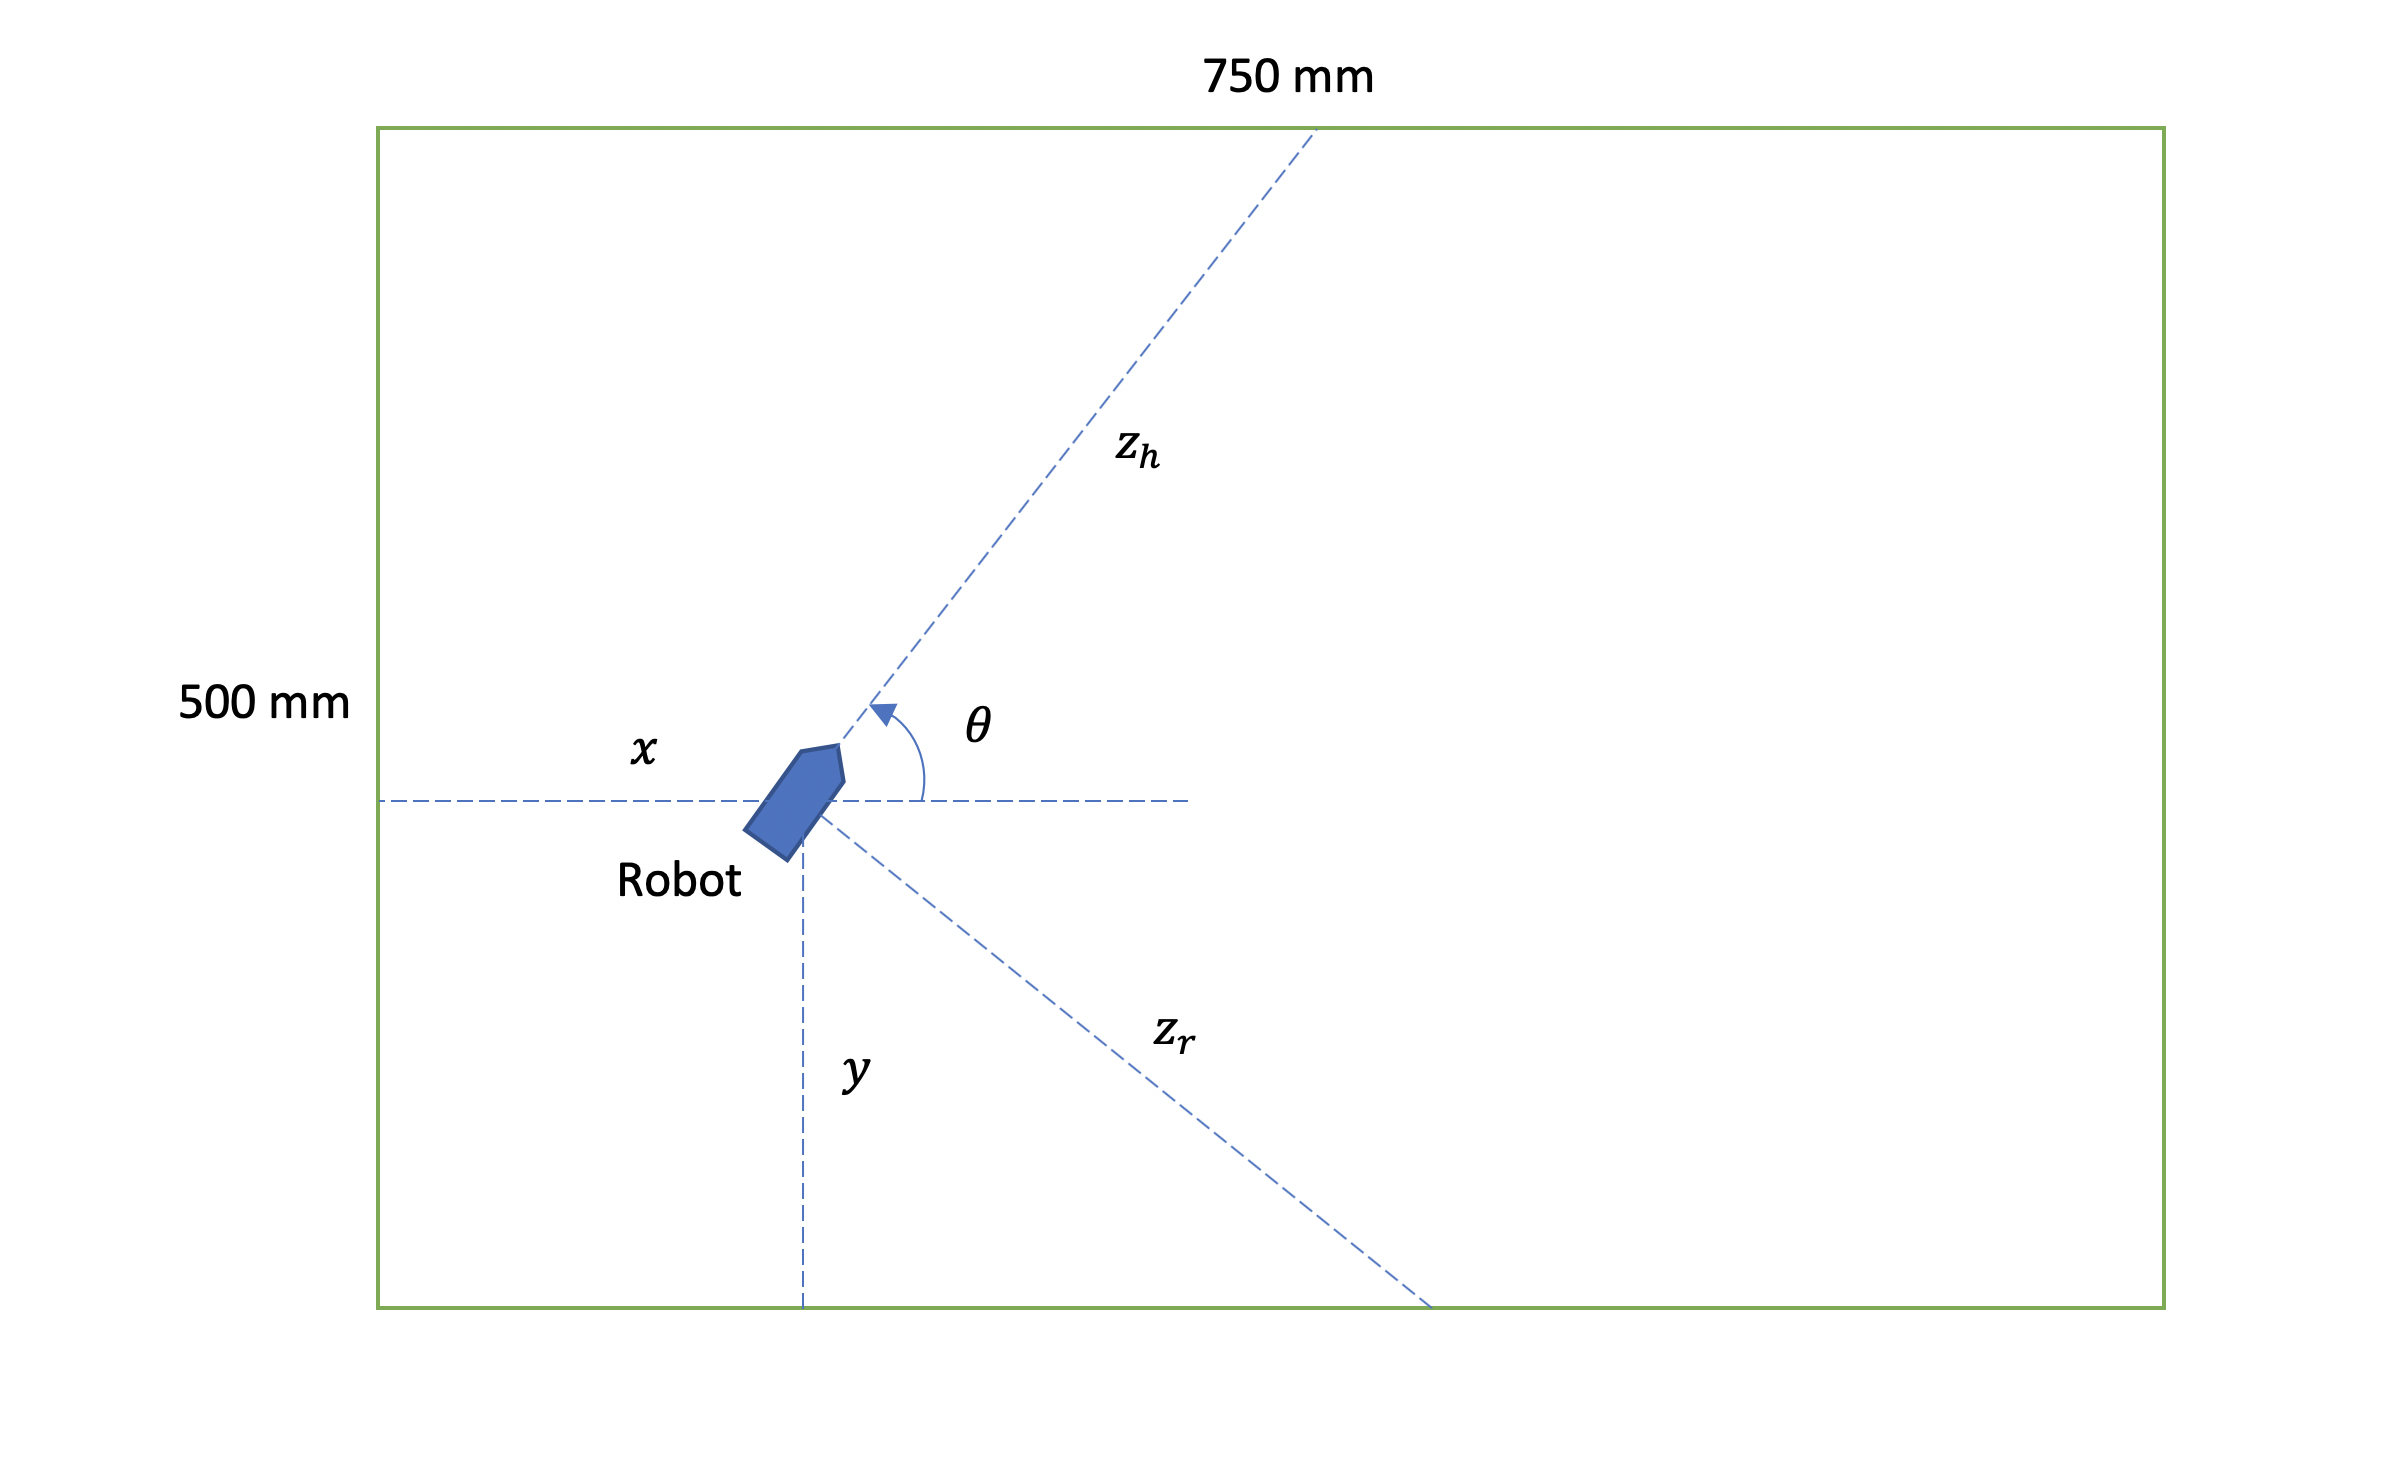

In [176]:
from IPython.display import Image
Image("/Users/scott/Pictures/Monosnap/EE209_1.png")

## 2.3 Define Kalman Filter

The kalman filter model I choose to use is called Extended Kalman Filter (EKF). The Kalman Filter works only on linear equations, but when problem became complicated and nonlinear terms are involved (especially dealing with trigonometry calculations). EKF is a method to eliminate non-linearity at point of estimate. Two processes are considered non-linear. The first one is system dynamics and the second one is measurement model:

$$\dot{x} = f(x,u) + w_x$$
$$z = h(x) + w_z$$

Both process update function $f(x,u)$ and $h(x)$ may involve various non-linear functions. To linearize them, we need to introduce Jacobian Matrix to calculate partial derivative of $f(x,u)$ and $h(x)$ for each state and input:

$$ F = \frac{\partial{f(x,u)}}{\partial{x}}\biggr |_ {x_t,u_t}\\ $$
$$ V = \frac{\partial{f(x,u)}}{\partial{u}}\biggr |_ {x_t,u_t}\\ $$

$$ H = \frac{\partial{h(\bar{x})}}{\partial{x}}\biggr |_ {\bar{x_t}}\\ $$

At certain time = $t$ (usually not every time step due to hardware implementation), we will activate our EKF to do state extimation, which can be divided into prediction update ($priori$), measurement and observation update ($posteriori$)


### 2.3.1 Priori

Let's assume at time $t = t_s^- + Ndt$ (N = 1,2,3...) we will activate our EKF in our controller (We will definitely not activate for each time step due to time limitation and source limitation in our controller). Based on previous $posteriori$ state and system dynamics, we can predict $priori$ state as:

$$ \bar{x} = f(\hat{x},u_t) $$


Also, we can calculate the $priori$ covariance matrix $\bar{P}$:

$$ \bar{P} = F\hat{P}F^T + VMV^T $$

Where $\hat{x}$ and $\hat{P}$ are $posteriori$ state and covariance matrix. $\hat{x}$ is initially set to start state and $\hat{P}$ is initially set to $I$

### 2.3.2 Measurement

After prediction our next state, we want to take measurement from our sensors based on our true state $x$:

$$ z = h(x) + w $$

We also want to measure our residual $y$ from our true measurement and our observation estimation $\bar{z}$:

$$ \bar{z} = h(\bar{x}) $$

Thus $y$ can be updated as:

$$ y = z - \bar{z} $$

### 2.3.3 Posteriori

We reach the final step of our EKF process. Based on measurement and prediction, we need to update our model so that probablistically the $posteriori$ state $\hat{x}$ will be more close our true state $x$, and our covariance matrix $\hat{P}$ will be smaller to $\bar{P}$. This is achieved by updating our Kalman Gain $K$, which can be treated as a weighted factor and shows how much does the EKF believe in 
system dynamic update ($priori$) or measurements: 

$$ K = \bar{P}H^T(H\bar{P}H^T + R)^{-1} $$
$$ \hat{x} = \bar{x} + Ky $$
$$ \hat{P} = (I-KH)\bar{P} $$

After getting $posteriori$, we reach at at time $t = t_s^+$. We will continue to run our robot starting at next time step, $t = t_s + 1$. We will not activate our EKF untill $t = t_s + (N+1)dt$

In [170]:
import numpy as np
import sympy as sp
from math import tan,sin,cos,atan
from numpy.random import randn
from numpy.linalg import inv
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython import display

class myRobot:
    def __init__(self,wheelRadius = 20, wheelDistance = 85, 
                 maxMotorSpeed = np.pi/2, dt_update = 0.5, 
                 gyro_bias = 0.05, Length = 750, Width = 500):
        
        print("initializing state and input......")
        self.x = np.array([20,20,np.pi/4,gyro_bias])
        self.u = np.array([0,0])

        # use symbolic term to initialize
        
        # system dynamics
        x,y,theta,u0,u1,r,d,time,bias= sp.symbols('x,y,theta,u0,u1,r,d,time,b')
        
        # sensor measurements
        l,w = sp.symbols('l,w')
        
        # initialize fixed parameter
        self.r = wheelRadius
        self.d = wheelDistance
        self.maxMotorSpeed = maxMotorSpeed
        self.motor_err = 0.05*self.maxMotorSpeed
        self.dt_update = dt_update
        self.L = Length
        self.W = Width
        
        
        self.std_laser = 10       # 10 mm standard deviation
        self.std_imu = 0.1         # 0.1 rad standard deviation
        self.gyro_bias = gyro_bias
        self.gyro_std = self.std_imu
        
        
        
        # compute jacobian of f and h in symbolic term
        self.f = sp.Matrix([[x+1/2*sp.cos(theta)*(u0+u1)*r*time],
                          [y+1/2*sp.sin(theta)*(u0+u1)*r*time],
                          [theta + (u1-u0)*r/d*time],
                           [bias]])
        
        self.h1 = sp.Matrix([[(l-x)*sp.cos(theta)+(w-y)*sp.sin(theta)],
                            [(l-x)*sp.sin(theta)+y*sp.cos(theta)],
                            [theta],
                            [bias]])
        
        self.h2 = sp.Matrix([[(w-y)*sp.sin(theta)+x*sp.cos(theta)],
                            [(l-x)*sp.sin(theta)+(w-y)*sp.cos(theta)],
                            [theta],
                            [bias]])
        
        self.h3 = sp.Matrix([[-x*sp.cos(theta)-y*sp.sin(theta)],
                            [-(w-y)*sp.cos(theta)-x*sp.sin(theta)],
                            [theta],
                            [bias]])
        
        self.h4 = sp.Matrix([[-y*sp.sin(theta)+(l-x)*sp.cos(theta)],
                            [-x*sp.sin(theta)+y*sp.cos(theta)],
                            [theta],
                            [bias]])
        
        
        
        
        # F is partial derivative of f over state x
        # V is partial derivative of f over input u
        # P is variance-covariance matrix
        # H is partial derivative of z over x
        # R is sensor noise variance - covariance matrix
        self.F = self.f.jacobian(sp.Matrix([x,y,theta,bias]))
        self.V = self.f.jacobian(sp.Matrix([u0,u1]))
        self.P = np.eye(4)
        
        self.H1 = self.h1.jacobian(sp.Matrix([x,y,theta,bias]))
        self.H2 = self.h2.jacobian(sp.Matrix([x,y,theta,bias]))
        self.H3 = self.h3.jacobian(sp.Matrix([x,y,theta,bias]))
        self.H4 = self.h4.jacobian(sp.Matrix([x,y,theta,bias]))
        
        self.R = np.array([[self.std_laser**2,0,0,0],[0,self.std_laser**2,0,0],
                           [0,0,self.std_imu**2,0],[0,0,0,self.gyro_std**2]])
        
        
        # initialize jacobian matrix using symbolic term
        self.subs = {x: self.x[0], y: self.x[1], theta: self.x[2], 
                     u0: self.u[0], u1: self.u[1], r:self.r, d:self.d, 
                     time:self.dt_update, bias:self.gyro_bias,
                    l: self.L, w: self.W}
        
        
        # save necessary parameters as instances for later update
        self.theta = theta
        self.u0 = u0
        self.u1 = u1
        self.sub_x = x
        self.sub_y = y
        
        # initialize counter
        self.ct = 0
        
        
    
    def predict(self,u):
        """
        Predict the state x as well as kalman gain and covariance matrix with input u
        
        Input:
        u: input control parameter specified as numpy(left_motor_speed, right_motor_speed)
        
        Update:
        x: state after move
        F: Jacobian matrix of state
        V: Jacobian matrix of input control parameters
        M: covariance matrix of input control parameter
        P: variance - covariance matrix
        """

        self.x = self.move(self.x,self.dt_update,u)
        # substitute parameter to Jacobian matrix F and V
        self.subs[self.theta] = self.x[2]
        self.subs[self.u0] = u[0]
        self.subs[self.u1] = u[1]
        
        # updates on F, V and M
        F = np.array(self.F.evalf(subs=self.subs)).astype(float)
        V = np.array(self.V.evalf(subs=self.subs)).astype(float)
        M = np.array([[(self.motor_err)**2, 0], 
                   [0, (self.motor_err)**2]])
        
        self.P = np.dot(F, self.P).dot(F.T) + np.dot(V, M).dot(V.T)
        
        self.ct += 1
    
    def move(self,x,dt,u):
        """
        Describe next state with input u, current state x and time increment dt
        
        Input: 
        x: state variable specified by numpy(xpos, ypos, heading, bias)
        u: input control parameter specified as numpy(left_motor_speed, right_motor_speed)
        dt: time increment
        
        Output:
        x: state after move

        """
        
        # check validity
        if any(u) > self.maxMotorSpeed:
            raise ValueError('motor velocity should not exceed maximum speed')

        # if x[0] > 750 or x[0] < 0 or x[1] > 500 or x[1] < 0:
            raise ValueError('robot is out of boundary')
            
        #if dt != self.dt_update:
         #   print("the robot is moving"

        
        
        # wheel's speeds and distances
        lws= u[0]*self.r
        rws = u[1]*self.r
        vel = 0.5*(lws+rws)
        lwd = lws*dt
        rwd = rws*dt

        # dynamic model 
        dx0 = cos(x[2])*vel*dt
        dx1 = sin(x[2])*vel*dt
        dx2 = (rwd-lwd)/self.d
        dx3 = 0
        
        x_next = x+np.array((dx0,dx1,dx2,dx3))
        x_next[2] = np.mod(x_next[2],2*np.pi)

        return x_next

    def measure(self,x,noise = False):
        """
        Take measurement from sensor to describe the state based on true state and error. Note that the
        gyroscope has a bias in measurement
        
        Input: 
        x: state variable specified by numpy(xpos, ypos, heading, bias)
        
        Output:
        z: measurements given by sensor
        """
        heading = np.mod(x[2],2*np.pi)
        z_e = np.zeros(4)
        
        print(heading)
        
        if heading >= 0 and heading < np.pi/2:
            front_dist = (self.L - x[0])*np.cos(heading) + (self.W - x[1])*np.sin(heading)
            right_dist = (self.L - x[0])*np.sin(heading) + x[1]*np.cos(heading)
            
        elif heading >= np.pi/2 and heading < np.pi:
            front_dist = (self.W - x[1])*np.sin(heading) + x[0]*np.cos(heading)
            right_dist = (self.L - x[0])*np.sin(heading) - (self.W - x[1])*np.cos(heading)
        
        elif heading >= np.pi and heading <= (3/2)*np.pi:
            front_dist = -x[0]*np.cos(heading) - x[1]*np.sin(heading)
            right_dist = -(self.W - x[1])*np.cos(heading) - x[0]*np.sin(heading)
            
        elif heading >= (3/2)*np.pi and heading <= 2*np.pi:
            front_dist = -x[1]*np.sin(heading) + (self.L-x[0])*np.cos(heading)
            right_dist = -x[0]*np.sin(heading) + x[1]*np.cos(heading)
            
        
        if noise:
            z_e = np.sqrt(self.R).dot(randn(4))
            
        z = np.array([front_dist,right_dist,x[2],x[3]]) + z_e
    
    
        return z
    
    def residual(self,z):
        """
        Find the residual between measurement and belief
        
        Input: 
        z: measurements given by sensor
        
        Output:
        y: residual between measurement and belief
        """
        #z[2] = np.mod(z[2],2*np.pi)
        y = z - self.measure(self.x)
        print(y)
        
        return y
    
    def update(self,y,z):
        """
        Based on residual, by finding the kalman gain 
        update the state and variance - covariance matrix to posteriori
        
        Input:
        y: residual
        
        Update:
        K: Kalman gain
        P: posteriori variance - covariance matrix
        x: posteriori state
        """
        heading = np.mod(z[2],2*np.pi)
        print(heading)
        print('------')
        
        self.subs[self.theta] = self.x[2]
        self.subs[self.sub_x] = self.x[0]
        self.subs[self.sub_y] = self.x[1]
        
        
        if heading >= 0 and heading < np.pi/2:
            H = np.array(self.H1.evalf(subs = self.subs)).astype(float)
        elif heading >= np.pi/2 and heading < np.pi:
            H = np.array(self.H2.evalf(subs = self.subs)).astype(float)
        elif heading >= np.pi and heading < (3/2)*np.pi:
            H = np.array(self.H3.evalf(subs = self.subs)).astype(float)
        elif heading >= (3/2)*np.pi and heading < 2*np.pi:
            H = np.array(self.H4.evalf(subs = self.subs)).astype(float)
            
            
        
        
        K1 = np.dot(self.P,H.T)
        K2 = inv(np.dot(H,self.P).dot(H.T)+self.R)
        self.K = K1.dot(K2)
        self.x = self.x + self.K.dot(y)
        self.P = (np.eye(4)-self.K.dot(H)).dot(self.P)
        
        #print("\t-- EKF updated successfully......")





# 3. Evaluation

You should implement and debug your algorithms in a simulated environment. You can choose to get the control
inputs from a human driver, or implement pre-programmed behavior.
Within the simulation, you should implement models of your sensor and actuator response (especially including
noise) to generate realistic sensor traces given the control inputs. Identify any numerical parameters that need to
be set, and explain how you selected the values of those parameters. Generating these models may require finding
information on hardware datasheets.

In [177]:
def simulation(myRobot,T,mode = 1,animation = True):
    
    """
    run simulation based on robot object passed in. Animation mode is set defaultly to be true
    
    Input:
    myRobot: robot object with EKF updating method passed in
    T: total simulation time
    animation: bool variable indicates activation of frame-by-frame animation
    
    Output:
    None
    """
    
    
    # initialize movement updating interval and input parameter
    dt = 0.1
    u = np.array((np.pi/2,np.pi/2))
    
    # initialize Scott as my robot
    Scott = myRobot()
    dt_update = Scott.dt_update
    step = dt_update/dt
    x = Scott.x
    e = Scott.motor_err
    
    x_traj = []
    y_traj = []
    x_priori = []
    y_priori = []
    x_post = []
    y_post = []
    x_measure = []
    y_measure = []
    
    
    for i in range(0,int(T/dt)+1):
        
        # simulate for different speed
        if i >= 200:
            u = np.array([1.4,0.1])
        if i >= 300:
            u = np.array([1.2,1.2])
        if i >= 400:
            u = np.array([0.5,1.5])
        if i >= 500:
            u = np.array([1,1])
        
        # make actual movement
        u_actual = u + e*randn(2)
        x = Scott.move(x,dt,u_actual)
        x_traj.append(x[0])
        y_traj.append(x[1])
        
        # activate EKF for every step
        if i % step == 0:
            
            # make prediction (priori)
            Scott.predict(u)
            x_priori.append(Scott.x[0])
            y_priori.append(Scott.x[1])
            
            # make observation (measurement)
            z = Scott.measure(x,noise = True)
            x_measure.append(z[0])
            y_measure.append(z[1])
            y = Scott.residual(z)
            
            # make correction (posteriori)
            Scott.update(y,z)
            x_post.append(Scott.x[0])
            y_post.append(Scott.x[1])
            
           
        if animation: 
            # plot animated graph if animation is activated
            plt.figure(figsize = (20,15))
            plt.title("Time = %.2f s" % (i*dt_update),fontsize = 18)
            plt.grid(True)
            plt.xlim((0,750))
            plt.ylim((0,500))
            plt.plot(x_traj,y_traj,marker = '*') 
            plt.plot(x_measure,y_measure, marker = 'x')
            plt.plot(x_post,y_post, marker = 'd')
            plt.legend(['trajectory','measurements','EKF estimates'],fontsize = 14)
            plt.show()
            display.clear_output(wait=True)
            
            
    if not animation:
        plt.figure(figsize = (20,15))
        plt.grid(True)
        plt.xlim((0,750))
        plt.ylim((0,500))
        plt.plot(x_traj,y_traj,marker = '*') 
        plt.plot(x_post,y_post, marker = 'd')
        plt.legend(['trajectory','EKF estimates'],fontsize = 14)
           
    
        
    


    

initializing state and input......
0.7842987007463386
0.7853981633974483
[17.62763051  2.49373555  0.02019076  0.16621318]
0.805588922480496
------
0.777124177712239
0.7797680552530968
[15.96970203 -5.54872334  0.14630448 -0.13118521]
0.9260725313562213
------
0.7717639492916658
0.7714693195625745
[21.47148669 -8.84697851 -0.03814558 -0.1430977 ]
0.7333237365394014
------
0.7743630975568057
0.7561947435049317
[ 8.900341    8.29464333  0.07446495 -0.02069971]
0.8306596920516097
------
0.7638705445751846
0.7624464211204101
[21.69139075 -4.92354996  0.18786967 -0.03750208]
0.950316095116583
------
0.7725111887158829
0.75542460771153
[12.8055185  -1.83398029  0.20938274  0.02193752]
0.9648073443355731
------
0.7744734395100596
0.7543101737483726
[ 1.91961156  9.23511138 -0.16398337 -0.0415743 ]
0.5903268079569627
------
0.7756058607348588
0.7583880441337485
[-1.87662041 18.1156016  -0.10636875 -0.09655495]
0.6520192970058166
------
0.774883095103253
0.7725370719257466
[15.52520145  7.17687

5.702967941949587
[  8.25469342 -10.27071454  -0.10251861   0.05225104]
5.600449330707518
------
5.825310486672209
5.829524742366119
[ 6.66646356 24.73677219  0.0262563   0.14893805]
5.855781043405829
------
5.942009981689745
5.924059814182858
[ -2.2804877  -32.175219     0.2222407    0.11956622]
6.1463005160527135
------
6.0534574957308935
6.081858322338832
[-6.19923408 -2.49135027 -0.14582105  0.09411713]
5.936037274883266
------
6.166419936761281
6.198210443367707
[-1.93286213e+00  1.51876040e+01  1.02182180e-03 -6.86028983e-03]
6.199232265167866
------
6.282580181448298
0.017847502398050885
[-14.39575617   3.05437373   6.12673639  -0.04269686]
6.144583892709035
------
0.08799759491277491
0.16868238443433842
[-30.96112604 -30.76075304  -0.16526314   0.1282599 ]
0.003419242933194261
------
0.08569931600690282
0.12284779543017454
[ -7.84186364 -32.15786528  -0.06099632   0.07574074]
0.061851473586042816
------
0.0916563520273124
0.09745102264960573
[-20.32049188  -9.42312633  -0.18925

0.09129225193780599
0.11076530138841179
[-26.77811406  -3.09393161  -0.21995892  -0.08220092]
6.173991685253398
------
0.09219417388643375
0.11372253109782766
[ 3.38555753  5.01474253 -0.09574055  0.08063564]
0.017981976181681306
------
0.08838914839160791
0.11115307561742126
[-10.7565899    1.80653001   0.12436337   0.08969272]
0.23551644694576807
------
0.08963306155680277
0.1067789975590501
[-1.87169252 10.23270571  0.08112663 -0.10336543]
0.1879056305811247
------
0.09498889329150456
0.10019769802608364
[-2.04250161  2.24555194  0.00639064 -0.15280443]
0.10658833457671066
------
0.10456254298522083
0.09786871096510598
[  4.07804246 -27.97522275   0.19281307  -0.04781581]
0.2906817801851377
------
0.11121088034109536
0.12111705731662112
[12.46245084 -2.11932721 -0.11939245 -0.04007326]
0.0017246072974448912
------
0.10577601309759418
0.12641006406766236
[-3.94739665e+00  1.70664537e+01  1.43119418e-02 -1.52125656e-02]
0.14072200589289646
------
0.10532100765135269
0.1134747371384172

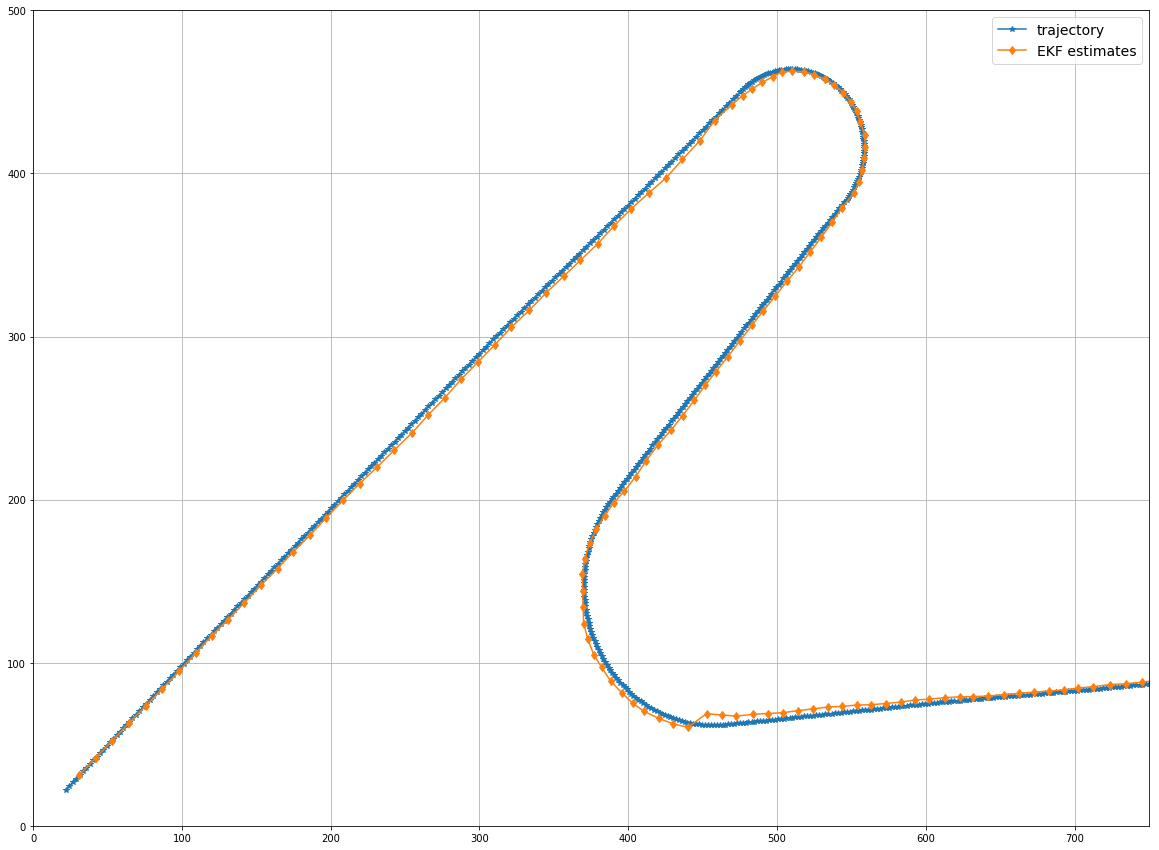

In [172]:
# run simulation
simulation(myRobot,100,animation = False)